# Part II: Gradient-based Explanations

## 0. Environment Setup

The resources for this session will be shared with you via Google Drive. To access the data, follow these steps:

1. Log in to your Google account
2. Open the shared link to access the folder
3. The folder should appear under the `Shared with me` section
4. Right-click on the folder `Organize > Add shortcut`
5. A pop-up window will appear, select `SharedImports` and add click `Add`
6. Finally, execute the cells below to give the Colab Notebook access to the GoogleDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import sys

shortcut_name = "SharedImports"
repo_path = f"/content/drive/MyDrive/{shortcut_name}/AISEC-SummerSchool-2025/XAI for Security/drebin_xai"
data_path = os.path.join(repo_path, "data")
sys.path.append(f"{repo_path}/src")

#### Run these cells to install and load necessary packages

In [24]:
# Install model and training environment
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.5 MB/s eta 0:00:00


In [49]:
# Load packages
import json
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from pathlib import Path
from typing import List, Dict
from sklearn.datasets import load_svmlight_file
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

---

# 2 Gradient-based explanations

In this section we will implement two approaches to use gradients to explain a machine learning method.

### 2.1 Vanilla Gradient

For vanilla gradients, the gradients of a model should be calculated w.r.t. to an input instance and the corresponding model output. This is not so different from the warm-up task, as a machine learning model can also be considered a large function.

### 2.2 Gradient x Input

In the previous approach, only the gradients of the model prediction in relation to the input were analyzed. This type of explanation can also be interpreted as sensitivity. They reflect how the prediction responds to infinitesimal changes in the inputs. However, the values of the input features have not been taken into account so far. As the name of the method suggests, the values of an input instance are multiplied by the gradients.

In [36]:
class GradientExplainer:
  def __init__(self, model):
    self.model = model
    self.model.eval()

  def __prep_input(input):
      # Ensure that input is tensor
      if isinstance(input, np.ndarray):
        input = torch.from_numpy(input)
        input = input.float()
      input = input.unsqueeze(0).clone().detach()
      return input

  def __get_logit(model_output):
    """
    Extracts the logit corresponding to the predicted class
    from a model's output tensor.

    Args:
        model_output (torch.Tensor): Output from the model,
                                     typically shape [1, num_classes]
                                     or scalar.

    Returns:
        torch.Tensor: The logit (un-normalized score) for the
                      predicted class.
    """
    # Remove the batch dimension if present (e.g., [1, num_classes] → [num_classes])
    output = model_output.squeeze(0)

    # If the output is a scalar (e.g., regression task), just return it
    if output.dim() == 0:
        return output

    # Otherwise (classification task), get the logit for the predicted class
    predicted_class = output.argmax().item()  # index of max logit
    return output[predicted_class]

  def vanilla_gradient(self, input, target=None):
    """
    Compute a vanilla gradient saliency map for a single input.

    Parameters
    ----------
    input : torch.Tensor
        Model input. Expected shape is `[1, ...]` (a single example with a
        leading batch dimension).
    target : Optional[int], default=None
        Intended class index to explain.

    Returns
    -------
    numpy.ndarray
        Gradient with respect to the input of the first (and only) item in the
        batch. Shape matches `input[0]` (i.e., the input without its batch
        dimension). Returned as a NumPy array.
    """
    input = GradientExplainer.__prep_input(input)

    #######################
    # TODO: YOUR CODE HERE
    #######################
    # Compute forward pass
    ### BEGIN SOLUTION
    input.requires_grad = True
    output = self.model(input)
    ### END SOLUTION

    logit = GradientExplainer.__get_logit(output)

    #######################
    # TODO: YOUR CODE HERE
    #######################
    # Compute gradient starting from logit
    ### BEGIN SOLUTION
    self.model.zero_grad()
    logit.backward()
    ### END SOLUTION

    return input.grad[0].detach().cpu().squeeze()

  def gradient_x_input(self, input, target=None):
    """
    Compute Gradient ⊙ Input attribution for a single input.

    Parameters
    ----------
    input : torch.Tensor
        Model input. Expected shape `[1, ...]` (single example with batch dim).
    target : Optional[int], default=None
        Intended class index to explain.

    Returns
    -------
    numpy.ndarray
        Element-wise product of input and its gradient, with the batch
        dimension removed.
    """
    #######################
    # TODO: YOUR CODE HERE
    #######################
    ### BEGIN SOLUTION
    grad = self.vanilla_gradient(input)
    gradients = input * grad
    ### END SOLUTION
    return gradients.squeeze()

### 2.3 Difference between Vanilla Gradient and Gradient x Input explanation

As mentioned earlier, vanilla gradients and the gradient × input method differ conceptually. Vanilla gradients measure the sensitivity of the model’s prediction with respect to each input feature, capturing how much a small change in a feature, e.g. a pixel, would affect the output. In contrast, the gradient × input approach also considers the magnitude of the input feature itself, providing a form of feature attribution: it indicates how much the actual value of a feature contributes to the model’s prediction.

In the following notebook you will apply the implementations form above to two examples that illustrate the difference.

**Example 1:**

Lets assume we have a simple model:

$f(x) = 2 * x_1 + 0.1 * x_2 $, and an input $ x = [1, 10] $

Use your own implementations from above to compute the different gradient explanations and compare the results.

In [ ]:
class SimpleModel(nn.Module):
  """
  Toy model implementing f(x1, x2) = 2*x1 + 0.1*x2 via a fixed linear layer.
  """
  def __init__(self):
    super().__init__()
    # Linear layer without bias that takes two values and outputs one input
    self.linear = nn.Linear(2, 1, bias=False)
    # Manually set weights to match f(x1, x2) = 2*x1 + 0.1*x2
    with torch.no_grad():
      self.linear.weight.copy_(torch.tensor([[2.0, 0.1]]))

  def forward(self, x):
    return self.linear(x)


def pprint_vec(name, v):
  """
  Pretty-print a 1D numeric vector with aligned, fixed-precision values.
  """
  v = np.asarray(v).ravel()
  s = np.array2string(
       v, precision=4, suppress_small=True, separator=', ',
      formatter={'float_kind': lambda x: f"{x: .2f}"}
  )
  print(f"{name} (len={v.size}): {s}")


# Create model
model = SimpleModel()

# Input to explain
x = torch.tensor([1., 10.])

#######################
# TODO: YOUR CODE HERE
#######################
# Compute vanilla gradient and gradient x input for the SimpleModel
# Store vanilla gradient in variable `vanilla_gradient` and
# GxI in variable `gradient_x_input`.
### BEGIN SOLUTION
explainer = GradientExplainer(model)
vanilla_gradient = explainer.vanilla_gradient(x)
gradient_x_input = explainer.gradient_x_input(x)
### END SOLUTION

pprint_vec("Vanilla Gradient", vanilla_gradient)
pprint_vec("Gradient × Input", gradient_x_input)

**Example 2**

In the second example we will analyze the differences in a more sophisticated use case, i.e. classification of handwritten digits. In the following notebook will:

1. Load MNIST sample data and perform data preparation steps
2. Implement a simple CNN model and training loop
3. Train the model for the classification task on the training split and provide validation performance
4. Load test instance to explain model predictions

In [ ]:
from mnist_utils import *

# Load data
mnist_path = f"{data_path}/mnist/mnist_train_small.csv"
train_loader, val_loader = load_and_prep_data(mnist_path)

# Build model
model = LitMNIST_CNN(lr=0.001)

# Train model
fit_model(model, train_loader, val_loader)


In [ ]:
# Load test data to explain
test_path = f"{data_path}/mnist/mnist_test.csv"
test_dat = load_test_data(test_path)

In [ ]:
# Your code here
# Initialize GradientExplainer object with trained model and generate
# vanilla gradient and gradient_x_input explanation of the first instace of the test data

explainer = GradientExplainer(model)
input, _ = test_dat[0]
print(input.shape)
vanilla_gradient = explainer.vanilla_gradient(input)
grad_x_input = explainer.gradient_x_input(input)

plot_gradients(input, vanilla_gradient, grad_x_input)

---

# 3. Saliency Maps for DeepDrebin (Gradients & Gradients × Input)

This notebook:
1. Loads a single **bundle** file (model + selector + selected feature names).
2. Loads a filtered **LIBSVM** dataset (labels `-1/+1` → `{0,1}`).
3. Splits into **train/val/test** using the same seed/splits stored in the bundle (for comparability).
4. Transforms with the bundled **SelectKBest** into the selected-feature space.
5. Picks **N malicious** samples (by label) and computes saliency with:
   - **Gradients**: $|\frac{\partial (\text{logit})}{\partial x}|$
   - **Gradients × Input**: $|x \cdot \frac{\partial (logit)}{\partial x}|$
6. Prints **top-K feature names** with scores and (optionally) saves a CSV.

In [25]:
from drebin_utils import *

In [29]:
# Set configs
DATA_PATH = f"{data_path}/drebin"

# Path to model bundle (model + hyperparameters)
BUNDLE_PATH = os.path.join(DATA_PATH, "drebin_bundle.pt")

# Path to data stored in LIBSVM format
LIBSVM_DATA = os.path.join(DATA_PATH, "drebin_filtered.libsvm.gz")

In [50]:
# Build model and load data
model, bundle = build_model(BUNDLE_PATH)
X, y = load_libsvm(LIBSVM_DATA, bundle["selector"], bundle["model_hparams"])

TypeError: build_model() missing 1 required positional argument: 'DEVICE'

#########################################
# SAMPLE 336
#########################################
Ground truth label: 1 (1=malware)
Predicted malware probability: 0.9944


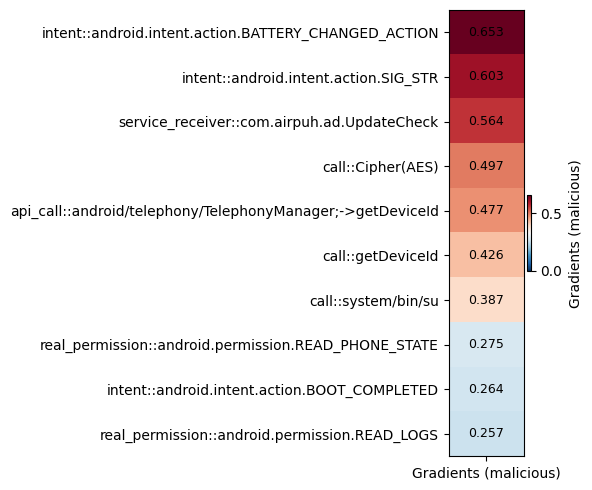

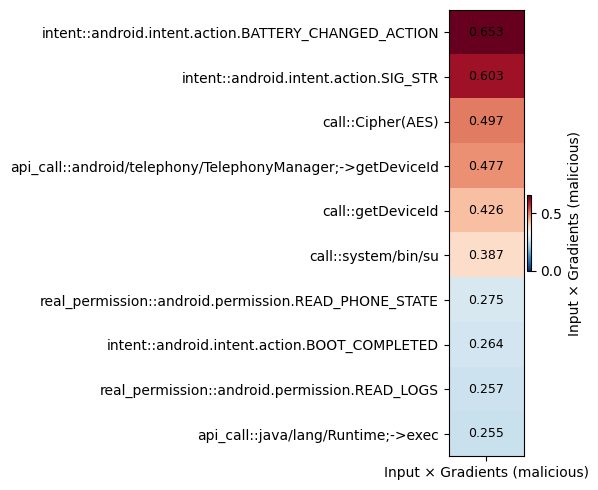

In [48]:
"""
Explain a single malware sample using Gradients and Input×Gradients.
Show only positive (malicious) contributions, sorted descending.
"""
# Select malware sample to explain
idx = np.where(y == 1)[0][0]
x = torch.from_numpy(X[idx])

#######################
# TODO: YOUR CODE HERE
#######################
### BEGIN SOLUTION
explainer = GradientExplainer(model)
grad = explainer.vanilla_gradient(x)
ixg = explainer.gradient_x_input(x)
### END SOLUTION

# Keep *only* positive contributions and take top-k
top_k = 10
grad_idx = topk_positive(grad, top_k)
ixg_idx  = topk_positive(ixg,  top_k)

# Build lists sorted by descending score (most malicious first)
grad_scores = np.array([grad[j] for j in grad_idx], dtype=float)
grad_names  = [fname(bundle["selected_names"], j) for j in grad_idx]

ixg_scores  = np.array([ixg[j]  for j in ixg_idx], dtype=float)
ixg_names   = [fname(bundle["selected_names"], j) for j in ixg_idx]

# Header
print(f"#########################################")
print(f"# SAMPLE {idx}")
print(f"#########################################")
print(f"Ground truth label: {int(y[idx])} (1=malware)")
p = float(predict_proba(model, X[idx:idx+1])[0])
print(f"Predicted malware probability: {p:.4f}")

# Heatmaps: most relevant on top (already sorted)
if len(grad_scores):
  plot_malicious_heatmap(grad_scores, grad_names, "Gradients (malicious)")
else:
  print("No positive (malicious) gradient contributions found.")

if len(ixg_scores):
  plot_malicious_heatmap(ixg_scores, ixg_names, "Input × Gradients (malicious)")
else:
  print("No positive (malicious) Input×Gradients contributions found.")

